In [10]:
import time
import random
import keras
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.src.layers import Conv1D, BatchNormalization, LeakyReLU, Dropout, Dense, Input, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, concatenate

from sources.utils import Config, zoom_frames, normalize_range, get_joint_collection_distances, pose_motion

In [11]:
random.seed(69)

In [12]:
config = Config()

In [13]:
def convolution1D(x, filters, kernel):
    x = Conv1D(filters, kernel_size=kernel, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    return x

def convolutions_block(x, filters):
    x = convolution1D(x, filters, 3)
    x = convolution1D(x, filters, 3)

    return x

def dense1D(x, filters):
    x = Dense(filters, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    return x

def build_jcd_block(x, filters):
    x = convolution1D(x ,filters * 2, 1)
    x = SpatialDropout1D(0.1)(x)

    x = convolution1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)

    x = convolution1D(x, filters, 1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    return x

def build_slow_motion_block(x, filters):
    x = convolution1D(x, filters * 2, 1)
    x = SpatialDropout1D(0.1)(x)

    x = convolution1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)

    x = convolution1D(x, filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    return x


def build_fast_motion_block(x, filters):
    x = convolution1D(x, filters * 2, 1)
    x = SpatialDropout1D(0.1)(x)

    x = convolution1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)

    x = convolution1D(x, filters,1)
    x = SpatialDropout1D(0.1)(x)

    return x


def build_main_block(x, filters):
    x = convolutions_block(x, filters * 2)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = convolutions_block(x, filters * 4)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = convolutions_block(x, filters * 8)
    x = SpatialDropout1D(0.1)(x)

    return x

def build_output_block(x, classes_number):
    x = GlobalMaxPooling1D()(x)

    x = dense1D(x, 128)
    x = Dropout(0.5)(x)
    x = dense1D(x, 128)
    x = Dropout(0.3)(x)
    x = Dense(classes_number, activation='softmax')(x)

    return x

In [14]:
def build_DD_Net(model_config):
    Distance = Input(name='Distance', shape=(model_config.frame_length, model_config.features_dimension))
    Motion = Input(name='Motion', shape=(model_config.frame_length, model_config.joints_number, model_config.joints_dimension))
    
    slow_diff, fast_diff = pose_motion(Motion, model_config.frame_length)

    # Joint Collection Distances
    model = build_jcd_block(Distance, model_config.filters)

    # Cartesian coordinates
    slow_diff = build_slow_motion_block(slow_diff, model_config.filters)
    fast_diff = build_fast_motion_block(fast_diff, model_config.filters)

    model = concatenate([model, slow_diff, fast_diff])

    model = build_main_block(model, model_config.filters)

    model = build_output_block(model, model_config.classes_number)
    
    model = Model(inputs=[Distance, Motion], outputs=model)
    
    return model

In [15]:
DD_Net = build_DD_Net(config)

In [16]:
DD_Net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Motion (InputLayer)         [(None, 32, 22, 2)]          0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 32, 22, 2)            0         ['Motion[0][0]']              
                                                                                                  
 lambda_4 (Lambda)           (None, 16, 22, 2)            0         ['Motion[0][0]']              
                                                                                                  
 Distance (InputLayer)       [(None, 32, 231)]            0         []                            
                                                                                            

In [17]:
def prepare_data(filename: str):
    data = pickle.load(open(config.data_directory + filename, "rb"))

    Labels = []
    Distances = []
    Motion = []

    print(f"Preparing data from {filename}...")

    for i in tqdm(range(len(data['skeleton']))):
        motion = np.copy(data['skeleton'][i]).reshape([-1, config.joints_number, config.joints_dimension])
        motion = zoom_frames(motion, config.frame_length, config.joints_number, config.joints_dimension)
        motion = normalize_range(motion)

        label = np.zeros(config.classes_number)
        label[data['label'][i] - 1] = 1

        distance = get_joint_collection_distances(motion, config)

        Distances.append(distance)
        Motion.append(motion)
        Labels.append(label)

    Distances = np.stack(Distances)
    Motion = np.stack(Motion)
    Labels = np.stack(Labels)

    return [Distances, Motion], Labels

In [18]:
X_train, Y_train = prepare_data("train.pkl")
X_valid, Y_valid = prepare_data("valid.pkl")

Preparing data from train.pkl...


100%|██████████| 1960/1960 [00:03<00:00, 519.59it/s]


Preparing data from valid.pkl...


100%|██████████| 840/840 [00:01<00:00, 539.24it/s]


In [19]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",
               optimizer=keras.optimizers.legacy.Adam(lr),
               metrics=['accuracy'])

In [20]:
def train(model, X_train, Y_train, X_valid, Y_valid, epochs=100):
    callbacks = []
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                     factor=0.5,
                                                     patience=5,
                                                     cooldown=5,
                                                     min_lr=5e-6)
    callbacks.append(lr_scheduler)
    
    history = model.fit(X_train,
                        Y_train,
                        batch_size=len(Y_train),
                        epochs=epochs,
                        verbose=True,
                        shuffle=True,
                        callbacks=callbacks,
                        validation_data=(X_valid, Y_valid)
                        )
    
    return model, history

In [21]:
DD_Net, training_history = train(DD_Net, X_train, Y_train, X_valid, Y_valid, epochs=300)

Epoch 1/300


2023-08-03 05:18:17.378151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 3.1855 - accuracy: 0.0735

2023-08-03 05:18:19.980066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step - loss: 3.1855 - accuracy: 0.0735 - val_loss: 2.7428 - val_accuracy: 0.0679 - lr: 0.0010
Epoch 2/300
1/1 [==============================] - 0s 331ms/step - loss: 2.9730 - accuracy: 0.0893 - val_loss: 2.6632 - val_accuracy: 0.1036 - lr: 0.0010
Epoch 3/300
1/1 [==============================] - 0s 246ms/step - loss: 2.8247 - accuracy: 0.1260 - val_loss: 2.6331 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 4/300
1/1 [==============================] - 0s 203ms/step - loss: 2.7062 - accuracy: 0.1367 - val_loss: 2.6233 - val_accuracy: 0.1262 - lr: 0.0010
Epoch 5/300
1/1 [==============================] - 0s 198ms/step - loss: 2.5963 - accuracy: 0.1582 - val_loss: 2.6178 - val_accuracy: 0.0905 - lr: 0.0010
Epoch 6/300
1/1 [==============================] - 0s 197ms/step - loss: 2.5103 - accuracy: 0.1776 - val_loss: 2.6112 - val_accuracy: 0.0845 - lr: 0.0010
Epoch 7/300
1/1 [==============================] - 0s 199ms/step - loss: 2.3691 - accuracy:

In [22]:
DD_Net.save_weights('../models/ddnet.h5')

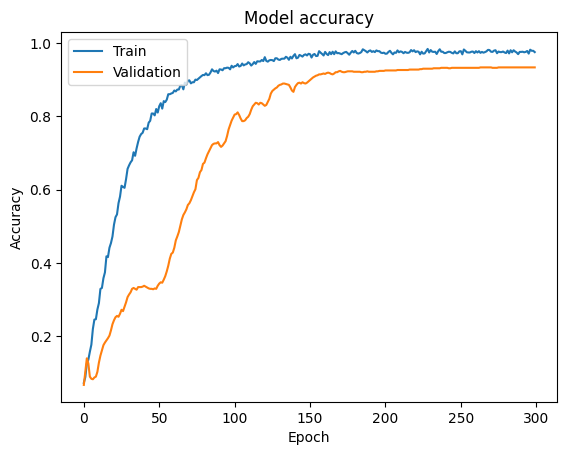

In [23]:
# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
start_time = time.time()
y = DD_Net.predict(X_train)
time.time() - start_time

2023-08-03 05:19:15.998920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 2s 16ms/step


2.0051510334014893

27/27 [==============================] - 0s 11ms/step


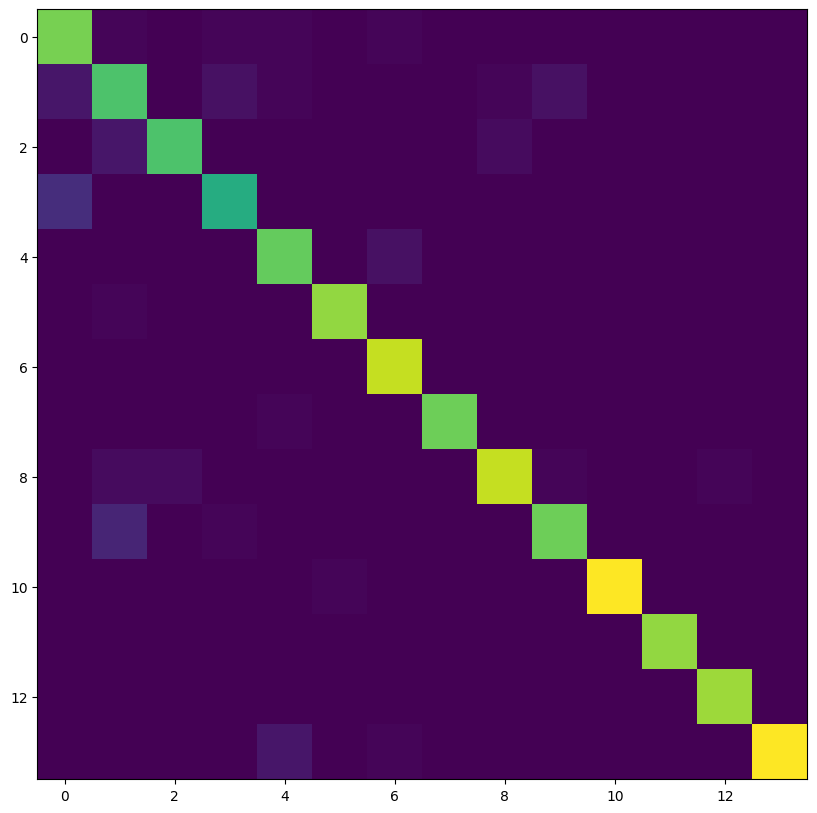

In [25]:
Y_pred = DD_Net.predict(X_valid)
cnf_matrix = confusion_matrix(np.argmax(Y_valid, axis=1), np.argmax(Y_pred, axis=1))
plt.figure(figsize=(10, 10))
plt.imshow(cnf_matrix)
plt.show()